In [1]:
import pandas as pd
import datetime as dt
import numpy as np

# data path, constants, etc.
import sys
datapath = '/Users/nhamilto/Documents/ATom/coderepo/ATom/'
sys.path.append(datapath)

# constants and parameters from data collection
import constants 

# signal latency from AT array
import offsets 

# plot things
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

SyntaxError: invalid syntax (constants.py, line 22)

In [2]:
from scipy import optimize

def cosine_fit_func(x, a, b, c):
    return a * np.cos(b * x)+c

### Speaker characterization data
signal latency at several fixed radial distances from the center of the speaker aperature as a function of azimuth angle

In [3]:
colnames = ['azangle'] + [x for x in range(120)]
speaker = pd.read_csv('../../data/speaker_char_raw_data_210818.csv', names=colnames, skiprows=1)

speaker['azangle'].ffill(inplace=True)
speaker = speaker.set_index('azangle').drop('4m', axis=0)
speaker.set_index(pd.to_numeric(speaker.index), inplace=True)
speaker['radius'] = np.concatenate(((2*np.ones(int(len(speaker.index)/2))).astype(int), (4*np.ones(int(len(speaker.index)/2+1))).astype(int)))
speaker.reset_index(inplace=True)
speaker.set_index(['radius','azangle'], inplace=True)


- calculate mean offset time,
- exclude outliers,
- separate by radial distance, 
- subtract minimum value, 

In [4]:
# get mean values over 120 records
meanoff = speaker.T.mean()

# remove and replace obvious outliers
meanoff.loc[2,[-40,40]] = np.nan
meanoff.interpolate(inplace=True)
meanoff.loc[4,[-100]] = np.nan
meanoff.bfill(inplace=True)

# extract data for radial distance = 2 m
rad2 = meanoff.xs(2, level=0) - meanoff.xs(2, level=0).min()
rad2 = rad2.reset_index()
rad2.columns = ['azangle', 'offset']

# extract data for radial distance = 4 m
rad4 = meanoff.xs(4, level=0) - meanoff.xs(4, level=0).min()
rad4 = rad4.reset_index()
rad4.columns = ['azangle', 'offset']

# fit cosine curve to data
rad2params, params_covariance = optimize.curve_fit(cosine_fit_func, np.radians(rad2['azangle']), rad2['offset'], p0=[0.15, 2, 0.15])
rad4params, params_covariance = optimize.curve_fit(cosine_fit_func, np.radians(rad4['azangle']), rad4['offset'], p0=[0.15, 2, 0.15])

rad2fit = cosine_fit_func(np.radians(rad2['azangle']), rad2params[0], rad2params[1], rad2params[2])
rad4fit = cosine_fit_func(np.radians(rad4['azangle']), rad4params[0], rad4params[1], rad4params[2])

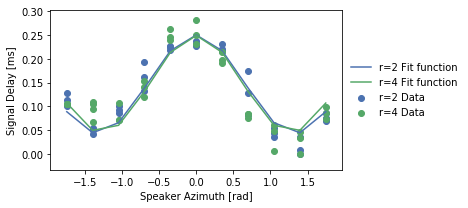

In [5]:
fig, ax = plt.subplots(figsize=(5,3))
ax.scatter(np.radians(rad2['azangle']), rad2['offset'], label='r=2 Data')
ax.plot(np.radians(rad2['azangle']), rad2fit,
         label='r=2 Fit function')

ax.scatter(np.radians(rad4['azangle']), rad4['offset'], label='r=4 Data', color='C1')
ax.plot(np.radians(rad4['azangle']), rad4fit,
         label='r=4 Fit function', color='C1')

ax.legend(loc=6, bbox_to_anchor=(1,0.5), frameon=False)

ax.set_xlabel('Speaker Azimuth [rad]')
ax.set_ylabel('Signal Delay [ms]')

fig.tight_layout()
fig.savefig('../figures/speaker_char_time_offsets.png', dpi=200, bbox_inches='tight')

### Signal latency
Time delays produced by the particulasr equipment in use can be another factor in accuracy of the AT array

In [6]:
colnames = ['Speaker', 'PA'] + [x for x in range(120)]
latency = pd.read_csv('../../data/latency_characterization_210818.csv', names=colnames)#, skiprows=1)

latency[['Speaker', 'PA']] = latency[['Speaker', 'PA']].ffill()#inplace=True)
latency.set_index(['Speaker', 'PA'], inplace=True)

# interpolate over missing data?
latency = latency.interpolate(axis=1)

meanlat = latency.T.mean()
meanlat = pd.DataFrame(meanlat)
meanlat = meanlat.groupby(['Speaker', 'PA']).mean().unstack()

In [12]:
meanlat.style.background_gradient(cmap='viridis', low=0.75, high=-0.25, alpha=0.5)

TypeError: background_gradient() got an unexpected keyword argument 'alpha'

In [8]:
# write to file!
meanlat.to_csv('../calibration_data/average_latency_220818.csv')
np.array(meanlat)

array([[1.05875   , 1.06001389, 1.06030556, 1.06488889, 1.06494444,
        1.06097222, 1.06158333, 1.06022222],
       [1.12      , 1.12      , 1.12      , 1.12434722, 1.12206944,
        1.125     , 1.125     , 1.12      ],
       [1.11554167, 1.11765278, 1.11593056, 1.11819444, 1.11965278,
        1.11826389, 1.11522222, 1.11504167],
       [1.04314257, 1.044875  , 1.05921592, 1.06113889, 1.05920833,
        1.06051389, 1.060875  , 1.04394444],
       [1.11075   , 1.11193056, 1.11      , 1.11398611, 1.11497222,
        1.11497222, 1.11405556, 1.11004167],
       [1.0805    , 1.08470833, 1.085125  , 1.08493056, 1.08505556,
        1.08504167, 1.08465278, 1.07798611],
       [1.13984722, 1.13931944, 1.13798611, 1.14      , 1.14004167,
        1.13959722, 1.139875  , 1.13877778],
       [1.09001389, 1.0905    , 1.10404167, 1.09431944, 1.09194444,
        1.09      , 1.09      , 1.08895833]])

### Instrument locations

In [7]:
locations = pd.read_csv('../NWTC_tomography_robotic.csv', names=['ID','northing','easting','elevation','device','subarea'])

In [8]:
locations.drop('ID', axis=1, inplace=True)
locations.set_index(['device','subarea'], inplace=True)

reindex = list(set(locations.index.get_level_values(0)))
reindex.sort()
reindex = ['Station {}'.format(int(x+1)) for x in [7,0,1,2,3,4,5,6]]
locations.T.columns.set_levels(reindex,level=0,inplace=True)
locations.sort_index(inplace=True)


In [9]:
# extract microphone positions
mics = locations.xs('MIC', level=1)

# extract speaker positions positions
speakers = locations.drop('MIC', level=1)
speakerlocs = speakers.mean(level=0)


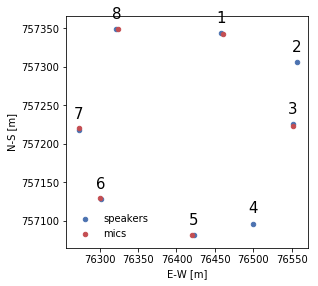

In [10]:
fig, ax = plt.subplots()
speakerlocs.plot.scatter(x='easting', y='northing', ax=ax)
mics.plot.scatter(x='easting', y='northing', ax=ax, color='C2')

for ii in range(8):
    t = ax.text(speakerlocs['easting'].iloc[ii], speakerlocs['northing'].iloc[ii]+10, str(ii+1), ha="center", va="bottom", size=15,)
    
ax.set_xlabel('E-W [m]')
ax.set_ylabel('N-S [m]')

ax.set_aspect('equal', 'box')

ax.legend(['speakers', 'mics'], frameon=False)

fig.tight_layout()

fig.savefig('../figures/inst_locations.png', dpi=200, bbox_inches='tight')

### Estimate locations of missing mics
for Station 2, estimate mic location as the average distance between speakers and mics, in the direction of Station 3.

for Station 4, estimate mic location as the average distance between speakers and mics, in the direction of Station 5.

In [11]:
micoffsets = mics - speakerlocs
micoffsets['dist'] = np.sqrt(micoffsets['northing']**2 + micoffsets['easting']**2 + micoffsets['elevation']**2)

avdist = micoffsets['dist'].mean()
avelevation = micoffsets['elevation'].mean()

micoffsets

,northing,easting,elevation,dist
device,,,,
Station 1,-1.17175,2.00775,0.03875,2.324986
Station 2,NaN,NaN,NaN,NaN
Station 3,-2.30100,-0.42625,-0.19475,2.348237
Station 4,NaN,NaN,NaN,NaN
Station 5,0.33600,-2.24775,0.00625,2.272733
Station 6,1.98675,-1.21825,0.06650,2.331465
Station 7,2.23300,0.27700,0.06375,2.251018
Station 8,0.87750,2.15400,0.07025,2.326942


In [14]:
dely = speakerlocs['northing'].iloc[2] - speakerlocs['northing'].iloc[1]
delx = speakerlocs['easting'].iloc[2] - speakerlocs['easting'].iloc[1]
dir23 = np.arctan2(dely, delx)

dely = speakerlocs['northing'].iloc[4] - speakerlocs['northing'].iloc[3]
delx = speakerlocs['easting'].iloc[4] - speakerlocs['easting'].iloc[3]
dir45 = np.arctan2(dely, delx)

# temp = micoffsets.copy()
micoffsets.loc['Station 2'] = [np.sin(dir23)*avdist, np.cos(dir23)*avdist, avelevation, avdist]
micoffsets.loc['Station 4'] = [np.sin(dir45)*avdist, np.cos(dir45)*avdist, avelevation, avdist]

In [15]:
mics = speakerlocs + micoffsets
mics.drop('dist',axis=1, inplace=True)
mics = mics[['northing', 'easting', 'elevation']]


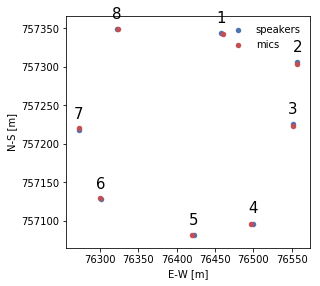

In [16]:
fig, ax = plt.subplots()
speakerlocs.plot.scatter(x='easting', y='northing', ax=ax)
mics.plot.scatter(x='easting', y='northing', ax=ax, color='C2')

for ii in range(8):
    t = ax.text(speakerlocs['easting'].iloc[ii], speakerlocs['northing'].iloc[ii]+10, str(ii+1), ha="center", va="bottom", size=15,)
    
ax.set_xlabel('E-W [m]')
ax.set_ylabel('N-S [m]')

ax.set_aspect('equal', 'box')

ax.legend(['speakers', 'mics'], frameon=False)

fig.tight_layout()
fig.savefig('../figures/inst_locations_add_missing.png', dpi=200, bbox_inches='tight')

In [17]:
# write to file!
mics.to_csv('../calibration_data/mic_locations_220818.csv')
np.array(mics)

array([[757342.515     ,  76460.405     ,   6094.11      ],
       [757304.32830741,  76556.79205156,   6094.13970833],
       [757223.495     ,  76551.17      ,   6093.872     ],
       [757095.62776897,  76497.0359615 ,   6094.20970833],
       [757081.445     ,  76420.334     ,   6094.116     ],
       [757129.534     ,  76299.993     ,   6094.066     ],
       [757220.544     ,  76273.092     ,   6094.115     ],
       [757349.609     ,  76324.109     ,   6094.266     ]])

In [18]:
# write to file!
speakerlocs.to_csv('../calibration_data/speaker_locations_220818.csv')
np.array(speakerlocs)

array([[757343.68675,  76458.39725,   6094.07125],
       [757306.6325 ,  76556.9445 ,   6094.13125],
       [757225.796  ,  76551.59625,   6094.06675],
       [757096.06975,  76499.3025 ,   6094.20125],
       [757081.109  ,  76422.58175,   6094.10975],
       [757127.54725,  76301.21125,   6093.9995 ],
       [757218.311  ,  76272.815  ,   6094.05125],
       [757348.7315 ,  76321.955  ,   6094.19575]])